In [1]:
import autograd.numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn
import time


# Example, Simple Linear Model

In [2]:
def linear_model(x, weights):
    return weights[0] + np.sum(x*weights[1:])

xSet = [rnd.normal(size = 4) for i in xrange(50)]


optw = rnd.randint(-10, 10, size = 5).astype('float64')
ySet = np.array([linear_model(x, optw) for x in xSet]) + rnd.normal(size = len(xSet))
print(optw)

[-9. -5. -6.  2.  1.]


In [3]:
S = zip(xSet, ySet)

In [4]:
S[:6]

[(array([-0.20018685, -0.25012634, -0.55787214,  0.0167039 ]),
  -8.4328507486615152),
 (array([ 0.98266685, -1.08854541,  0.73551494,  0.02805773]),
  -4.5436114945634491),
 (array([-1.31784553,  0.02330851,  1.09291352,  0.94662018]),
  -0.5617216298637222),
 (array([-1.21100346,  0.2193245 , -1.9089821 , -0.19479574]),
  -7.5629981264538557),
 (array([-2.63906237, -0.35430306,  0.48821395, -1.75494382]),
  6.6743791820218794),
 (array([-0.97776622,  0.60799746, -0.19152911,  0.53244721]),
  -7.7007060324746517)]

In [5]:
theta = rnd.randint(-10, 10, size = 5) + rnd.normal(size = 5)
# At first sight, we can go with a simple for loop over all samples - but this is not the most effcient way:
# we should use the dot product between the data matrix and the weight in this simple case
predictedY = [linear_model(x, theta) for x in xSet]
# Print the error
print np.sum((predictedY - ySet)**2)

19747.252892


In [6]:
# The objective function measures the error of our prediction for a given sample set S
def objective_function(w, S):
    return np.sum([(linear_model(x, w) - y)**2 for x,y in S])# + np.sqrt(np.sum(w**2))

# evaluate the error on the random guess
objective_function(theta, S)

19747.252891975793

In [7]:
# Manual Differentiation
# Ex  = (f(x,w) - y)^2 = f(x,w)^2 - 2*f(x,w)*y + y^2
# Ex/dw = (f(x,w)^2 - 2*f(x,w)*y)/dw    | f(x) = g(h(x)) =>  f'(x) = g'(h(x))h'(x)
#       = 2 * f(x,w) * (f(x,w)/dw) - 2*(f(x,w)/dw)*y
#   where 
#     f(x,w)/dw = (1, x_1, ... x_d)
def objective_function_gradient(theta, S):
    return np.sum([2*(linear_model(x, theta)*np.append(1, x)) - 2*np.append(1, x)*y for x,y in S], axis = 0)
    
# Automatic Differentiation !
from autograd import grad
objective_function_gradient_auto = grad(objective_function)

In [8]:
print objective_function_gradient(theta, S)
print objective_function_gradient_auto(theta, S)

[   84.02573403  1121.91602439  1395.86004973  -497.61596128   752.45258534]
[   84.02573403  1121.91602439  1395.86004973  -497.61596128   752.45258534]


In [9]:
# There is however a disatvantage:
%timeit objective_function_gradient(theta, S)
%timeit objective_function_gradient_auto(theta, S)

100 loops, best of 3: 2.94 ms per loop
10 loops, best of 3: 23.6 ms per loop


# Gradient Descent

## Batch Gradient Descent

Batch Gradient Descent takes all data into consideration

In [72]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    theta -= learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 416 iterations in 1.75600004196 seconds.


In [73]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))

[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000092851411


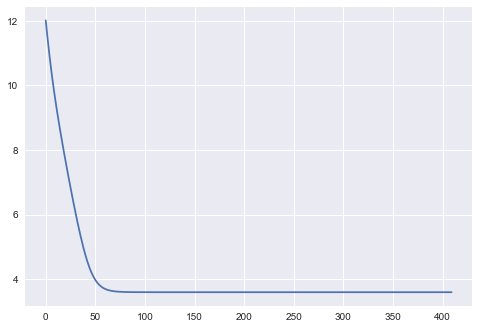

In [28]:
plt.plot(np.log(error))
plt.show()

## Stochastic gradient descent 

Stochastic Gradient Descent takes only single samples when computing gradients. The norm of the gradient will like not be zero when checking terminal condition.

In [47]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
maxIter = 100

t = time.time()
condition = True
niter = 0
while condition:
    for j in xrange(len(S)):
        _S = S[j:j+1]
        gradient = gradient_fun(theta, _S)
        theta -= learningRate*gradient
        error.append(objective_function(theta, _S)) 
    niter += 1
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 101 iterations in 0.704999923706 seconds.


[-8.7412336  -5.03363143 -6.35127418  2.17466085  0.78118546]
[-9. -5. -6.  2.  1.]
Objective at theta 36.583200 and at orginal weights 49.487761
Gradient at theta: 1.6528150448340153


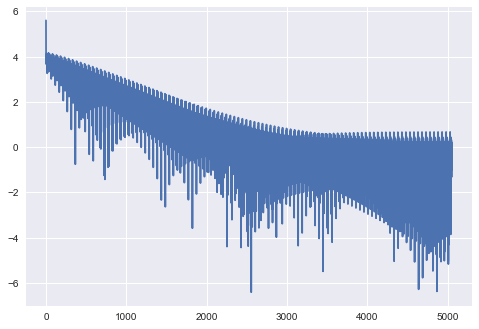

In [48]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Mini-Batch Gradient Descent

This methods only considers small batches of data. The term epoch refers to the number of time whole dataset has been seen.

In [65]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
localError = []
globalError = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
batchSize = 10
maxIter = 100

t = time.time()
for epoch in xrange(500):
    rnd.shuffle(S)    
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    for _S in batches:
        gradient = gradient_fun(theta, _S)
        theta -= learningRate*gradient
        localError.append(objective_function(theta, _S))
    globalError.append(objective_function(theta, S))

print 'Computed in %s seconds' % (time.time() - t)

Computed in 2.48300004005 seconds


[-8.72581838 -5.04081205 -6.36292833  2.17652563  0.77968323]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566949 and at orginal weights 49.487761
Gradient at theta: 0.3522467267535883


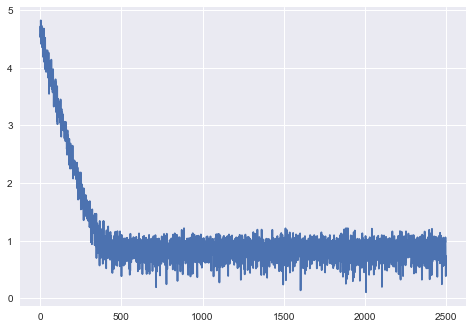

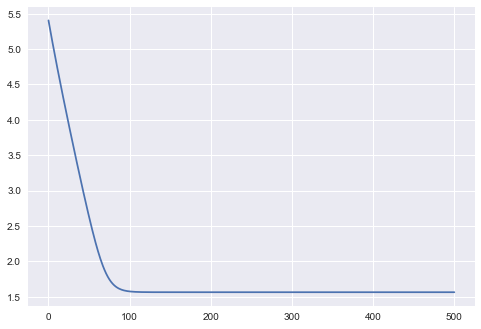

In [66]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(localError))
plt.show()
plt.plot(np.log10(globalError))
plt.show()

# Advances in Gradient Descent

## Momentum update

In [282]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.01
gamma = 0.1
maxIter = 1000

t = time.time()
condition = True
niter = 0
gradupdate = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradupdate = gradupdate*gamma + learningRate*gradient
    theta -= gradupdate#theta*gamma + learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 35 iterations in 0.155999898911 seconds.


[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000066133023


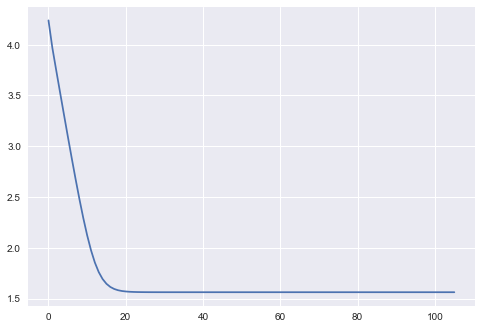

In [281]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

### Mini Batch Variant

Computed in 2.44999980927 seconds
[-8.71972278 -5.08641262 -6.34970427  2.22015009  0.80270348]
[-9. -5. -6.  2.  1.]
Objective at theta 36.946332 and at orginal weights 49.487761
Gradient at theta: 11.0707919903727650


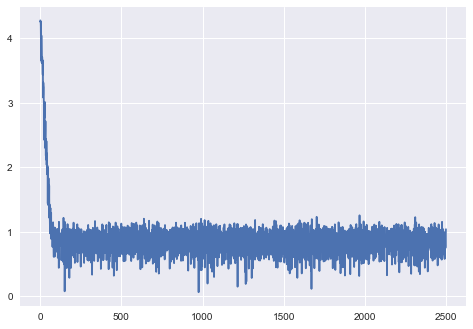

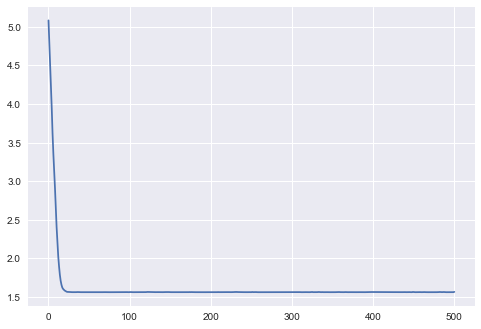

In [264]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
localError = []
globalError = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
gamma = 0.9
batchSize = 10
maxIter = 100

t = time.time()
for epoch in xrange(500):
    rnd.shuffle(S)    
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    gradupdate = 0
    for _S in batches:
        gradient = gradient_fun(theta, _S)
        gradupdate = gradupdate*gamma + learningRate*gradient
        theta -= gradupdate
        localError.append(objective_function(theta, _S))
    globalError.append(objective_function(theta, S))

print 'Computed in %s seconds' % (time.time() - t)
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(localError))
plt.show()
plt.plot(np.log10(globalError))
plt.show()

## Nesterov Accelerated Momentum

In [135]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
gamma = 0.9
maxIter = 1000

t = time.time()
condition = True
niter = 0
previousGradient = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta - previousGradient*gamma, S)
    theta -= previousGradient*gamma + learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 399 iterations in 1.58700013161 seconds.


[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000092679353


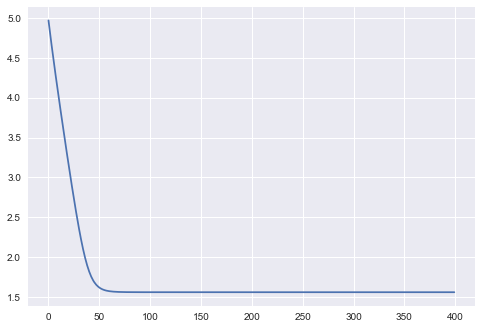

In [136]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Adagrad

In [217]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 100
gradientHistory = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradientHistory += (gradient**2)
    theta -= (learningRate/np.sqrt(gradientHistory + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 84 iterations in 0.343000173569 seconds.


[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000054146745


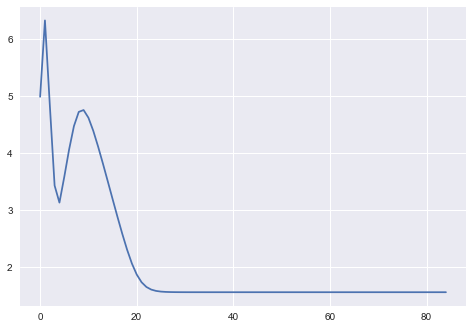

In [218]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Adadelta

Naive computation using window size

In [195]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 1
windowSize = 100
gamma = 0.999
gradientHistory = np.zeros((len(theta), windowSize))
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradientHistory = np.roll(gradientHistory, 1)
    gradientHistory[:, 0] = gradient
    correctionTerm = (gradientHistory**2).mean(axis = 1)
    #print correctionTerm
    theta -= (learningRate/np.sqrt(correctionTerm + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 152 iterations in 0.618000030518 seconds.


[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000051917905


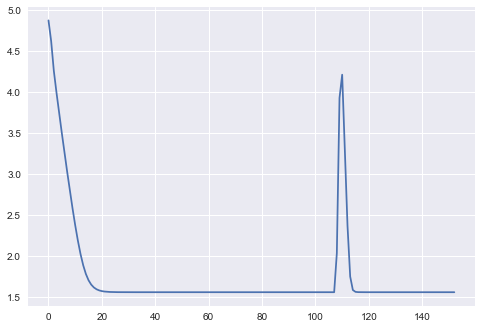

In [196]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

Implementation using  decaying average

In [166]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 1#0.1
gamma = 0.999
previousGradient = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    previousGradient = gamma*previousGradient + (1 - gamma)*((learningRate*gradient)**2)
    #print correctionTerm
    theta -= (learningRate/np.sqrt(previousGradient + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 51 iterations in 0.214999914169 seconds.


[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000055982053


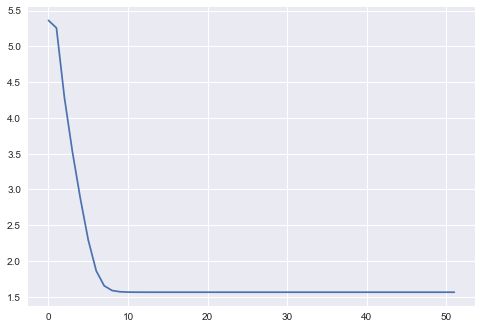

In [167]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Adam

Additionally adaps momentum for each parameter.

In [250]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 1#0.1
beta1 = 0.9
beta2 = 0.999
m = np.zeros_like(theta)
v = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    niter += 1
    gradient = gradient_fun(theta, S)
    m = beta1*m + (1 - beta1)*gradient
    v = beta2*v + (1 - beta2)*(gradient**2)
    mt = m/(1. - beta1**niter)
    vt = v/(1. - beta2**niter)
    theta -= ((learningRate*mt)/(np.sqrt(vt) + epsilon)) # <- no gradient term
    
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 531 iterations in 2.06900000572 seconds.


[-8.72712974 -5.03999392 -6.36391103  2.17606322  0.77879894]
[-9. -5. -6.  2.  1.]
Objective at theta 36.566588 and at orginal weights 49.487761
Gradient at theta: 0.0000000054758447


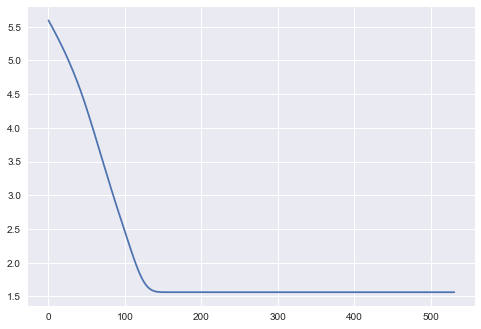

In [251]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

# Code optimization

## Differentiation

In [ ]:
# Maybe it can be imporoved by moving away the data
class SimpleModel(object):
    
    def __init__(self, S):
        self.x, self.y = zip(*S)
        self.objective_gradient = grad(self.objective)
        
    def model(self, weights):
        return np.array([weights[0] + np.sum(x*weights[1:]) for x in self.x])
        
    def objective(self, theta):
        return np.sum((self.model(theta) - self.y)**2)
        
sm = SimpleModel(S)
print objective_function(theta, S)
print sm.objective(theta)
print objective_function_gradient(theta, S)
print sm.objective_gradient(theta)
%timeit objective_function_gradient(theta, S)
%timeit sm.objective_gradient(theta)

In [ ]:
def linear_model_m(x, theta):
    return np.dot(x, theta[1:]) + theta[0]

#linear_model_m(xSet, np.array([10000, 1,10,100, 1000]))
def objective_function_m(theta, xMatrix, yValues):
    return np.sum((linear_model_m(xMatrix, theta) - yValues)**2)

# def objective_function_m_gradient(theta, xMatrix, yValues):
#     _x = np.append(np.ones((np.shape(xMatrix)[0], 1)), xMatrix, axis = 1)
#     return 2*np.dot(linear_model_m(xMatrix, theta), _x) - 2*
#     #return np.sum([2*(linear_model_m(xMatrix, theta)*_x) - 2*np.append(1, x)*y for x,y in S], axis = 0)

print x,y
objective_function_m(theta, x, y)

In [ ]:
y = zip(*S)[1]
x = np.array(zip(*S)[0])
print np.shape(x), np.shape(y)
print objective_function_m(optw, x,y)

objective_function(optw, S)
_dx = grad(objective_function)#(optw, S)
print objective_function(optw, S), _dx(theta, S)

In [ ]:
y = zip(*S)[1]
x = np.matrix(zip(*S)[0])
print np.array(x[:6])
_x = np.append(np.ones((np.shape(x)[0], 1)), x, axis = 1)
print linear_model_m(x, theta)[:6]
print _x[:6]
print 2*np.dot(linear_model_m(x, theta), _x)
print (np.array(_x[:6]).T * y[:6]).T
print 2*np.dot(linear_model_m(x, theta), _x) - 2*(np.array(_x).T * y).T

In [ ]:
# #_m = np.array([[1,2,3],[4,5,6],[7,8,9]])
# #_c = np.array([0,1,2])
# #_m * _c
# _m = np.array(xrange(12)).reshape((4,3))
# _c = np.array([10,200,3000,4000])
# print (_m.T * _c).T
# #_m

In [ ]:
x, y = zip(*S)

theta = rnd.normal(size = 5)#rnd.randint(-10, 10, size = 5) + rnd.normal(size = 5)*50
error = [objective_function_m(theta, x, y)]
dx = grad(objective_function_m)
t = time.time()
for epoch in xrange(20):
    rnd.shuffle(S)
    batchSize = 15
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    for i in xrange(30):
        for _S in batches:
            x, y = zip(*_S)
            theta -= 0.01*dx(theta, x, y)
            error.append(objective_function_m(theta, x,y))
print 'Computed in %s seconds' % (time.time() - t)

In [ ]:
print(theta)
print(optw)
plt.plot(np.log(error))
plt.show()